In [ ]:
'''
2/23  0.0.1  完成基本计算流程 
2/24  0.0.2  可视化中间结果 
3/17  0.1.0  结构变化=>64m 
3/18  1.0.0  代码重构 
3/25  1.1.0  更改力每次移动为0.1m 
3/26  1.1.1  实现zk活载 
4/2   2.0.0  代码重构 
4/7   2.1.0  支持160m桥 
4/8   2.2.0  增加64m, 160m桥子类 
4/11  2.2.1  完成疲劳、强度检算 
4/12  2.2.2  完成刚度、整体局部稳定性检算 
4/16  2.2.3  完成截面调节模块 
'''
'''
TODO:
- get_units_axial_forces_moment需检查和self.units顺序是否对应
- get_one_unit_axial_force_moment中get_u_and_v中node_num应该与units.keys()比较而不是bc_nodes_nums
- setter => 自动计算
- reduce_K 修改
- 添加Checker 类
'''

### 导入模块

In [49]:
%load_ext autoreload
%autoreload 2

from bridge_base import ZkLoad
from bridge import Bridge_64, Bridge_160

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 输入参数

In [50]:
# 常量
E = 21 * 10**10           # 杨氏模量 (Pa)
P = 1                     # 外力    (kN)
h = 2.52                  # 恒载    (kN)


bottom_chord_length = 8.   # 下弦杆长度/下节点间距 (m)

path = './data/'
bridge_len = 160

if bridge_len == 64:
    bridge = Bridge_64()
    bottom_chord_nodes_nums = [1, 3, 5, 7, 9, 11, 13, 15, 16]  # 下弦杆节点编号

elif bridge_len == 160:
    bridge = Bridge_160()
    # [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 40]
    bottom_chord_nodes_nums = list(range(1, 40, 2)) + [40]

In [3]:
'''
步长 = 0.1m

       6.4      0             200    
     均布荷载   填充          集中荷载                     均布荷载
{| | | | | |} . . . {#  .  #  .   #  .  #}  . . .  {| | | | | |}
    桥长度       0.8    1.6     1.6   1.6       0.8   桥长度      
'''

uniform_load = [6.4 for i in range(int(bridge.length / 0.1) + 1)] # 均布荷载，每个力间隔0.1m
padding = [0 for i in range(int(0.8 / 0.1) - 1)] # 填充0

# 集中荷载，每个间隔0.8m，与均布荷载相距0.8m
conc_load = [200] + padding + [0] + padding + [200] + padding + \
            [0] + padding + [200] + padding + [0] + padding + [200]

load = uniform_load + padding + conc_load + padding + uniform_load

outside_padding = [0 for i in range(int(bridge.length / 0.1) + 1)]
load = outside_padding + load + outside_padding

In [52]:
zk_load = ZkLoad(bridge.length)

### 载入数据

In [54]:
bridge.load_data(path)
bridge.load_params(E=E, P=P, h=h, 
                   bottom_chord_nodes_nums=bottom_chord_nodes_nums,
                   bottom_chord_length=bottom_chord_length, 
                   load=zk_load)

### 计算单元刚度矩阵

In [55]:
for unit in bridge.units.values():
    print('单元 %d\n%s' % (unit.num, unit.kij))

单元 1
[[ 2.859e+08  3.931e+08 -2.859e+08 -3.931e+08]
 [ 3.931e+08  5.405e+08 -3.931e+08 -5.405e+08]
 [-2.859e+08 -3.931e+08  2.859e+08  3.931e+08]
 [-3.931e+08 -5.405e+08  3.931e+08  5.405e+08]]
单元 2
[[ 7.004e+08  0.000e+00 -7.004e+08 -0.000e+00]
 [ 0.000e+00  0.000e+00 -0.000e+00 -0.000e+00]
 [-7.004e+08 -0.000e+00  7.004e+08  0.000e+00]
 [-0.000e+00 -0.000e+00  0.000e+00  0.000e+00]]
单元 3
[[ 9.262e-24  1.513e-07 -9.262e-24 -1.513e-07]
 [ 1.513e-07  2.470e+09 -1.513e-07 -2.470e+09]
 [-9.262e-24 -1.513e-07  9.262e-24  1.513e-07]
 [-1.513e-07 -2.470e+09  1.513e-07  2.470e+09]]
单元 4
[[ 1.111e+09  0.000e+00 -1.111e+09 -0.000e+00]
 [ 0.000e+00  0.000e+00 -0.000e+00 -0.000e+00]
 [-1.111e+09 -0.000e+00  1.111e+09  0.000e+00]
 [-0.000e+00 -0.000e+00  0.000e+00  0.000e+00]]
单元 5
[[ 1.425e+08 -1.959e+08 -1.425e+08  1.959e+08]
 [-1.959e+08  2.694e+08  1.959e+08 -2.694e+08]
 [-1.425e+08  1.959e+08  1.425e+08 -1.959e+08]
 [ 1.959e+08 -2.694e+08 -1.959e+08  2.694e+08]]
单元 6
[[ 7.004e+08  0.000e+00 -

### 总体刚度矩阵

In [56]:
bridge.K

array([[ 9.862e+08,  3.931e+08, -2.859e+08, ...,  0.000e+00,  0.000e+00,
         0.000e+00],
       [ 3.931e+08,  5.405e+08, -3.931e+08, ...,  0.000e+00,  0.000e+00,
         0.000e+00],
       [-2.859e+08, -3.931e+08,  1.539e+09, ...,  0.000e+00,  0.000e+00,
         0.000e+00],
       ...,
       [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  5.093e+08,  0.000e+00,
         0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,  8.429e+08,
        -1.959e+08],
       [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00, -1.959e+08,
         2.694e+08]])

In [11]:
bridge.K.shape

(32, 32)

In [6]:
bridge.bottom_chord_nodes_nums

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 40]

### 计算下弦杆结点竖向位移

In [7]:
bridge.get_nodes_vdisps()

所有节点竖向位移已计算完毕.


In [14]:
bridge.reduced_K.shape

(29, 29)

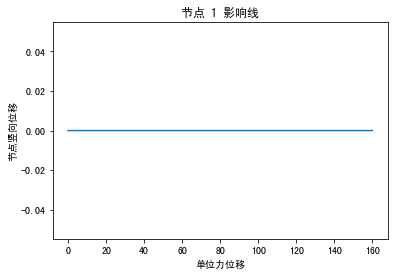

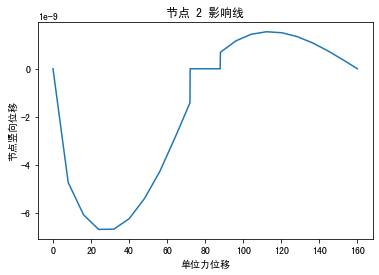

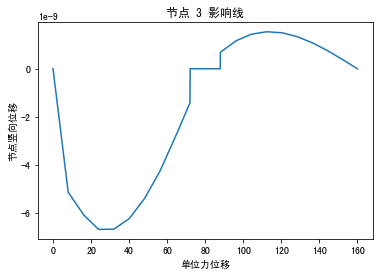

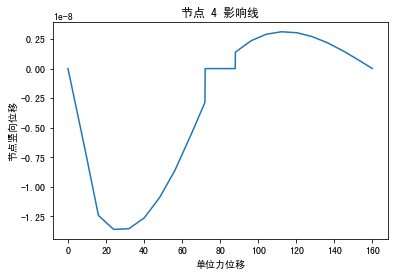

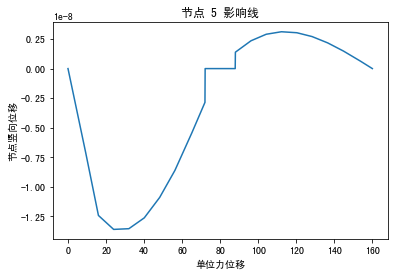

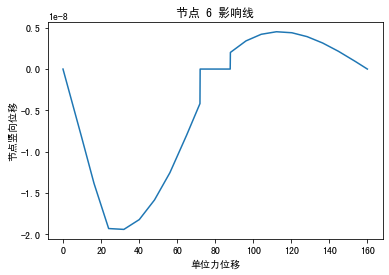

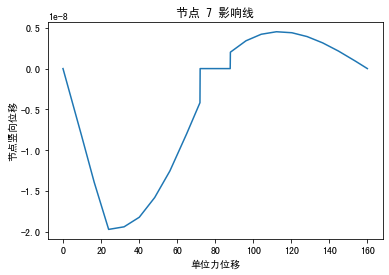

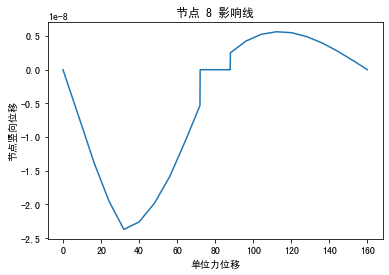

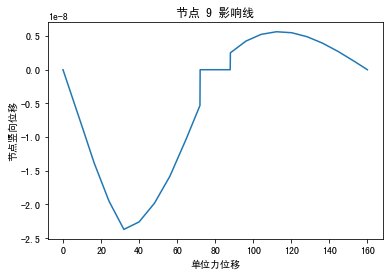

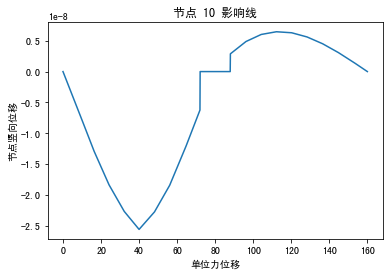

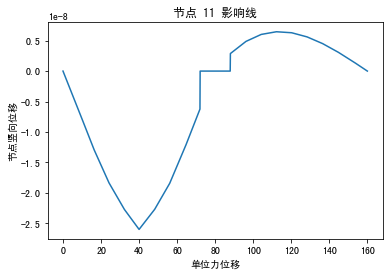

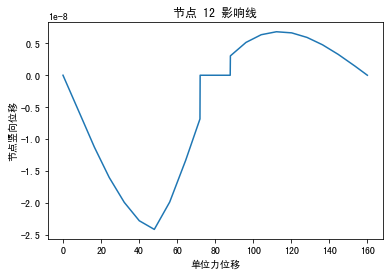

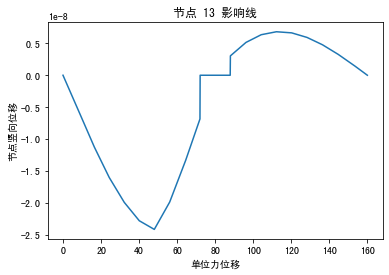

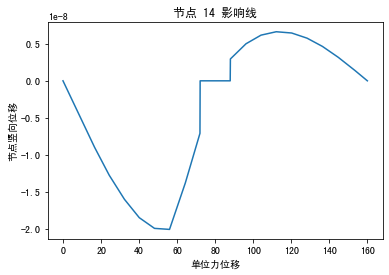

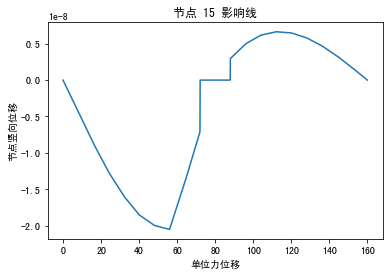

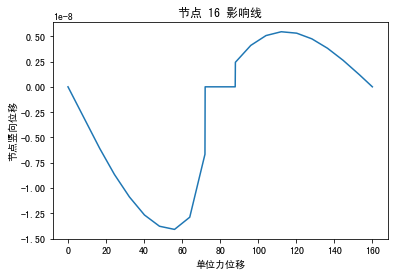

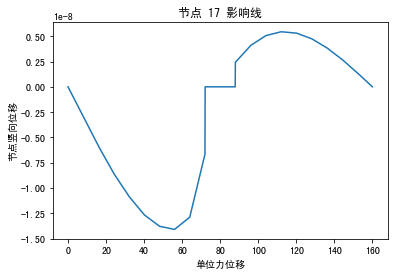

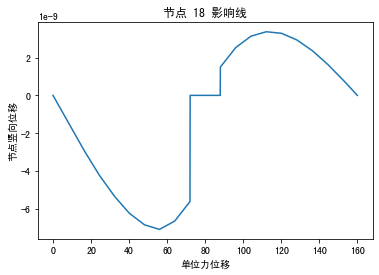

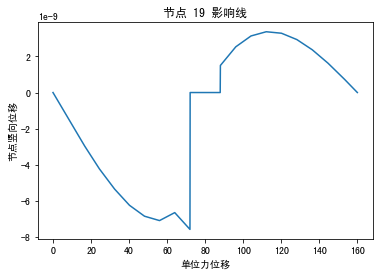

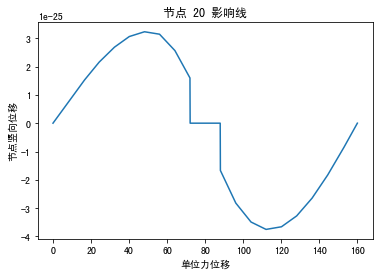

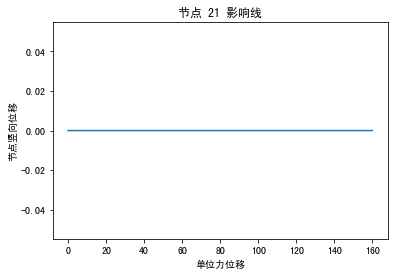

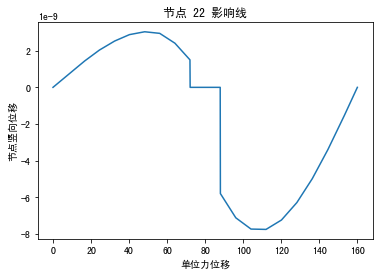

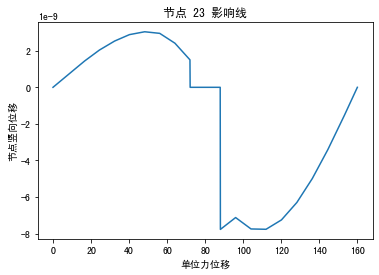

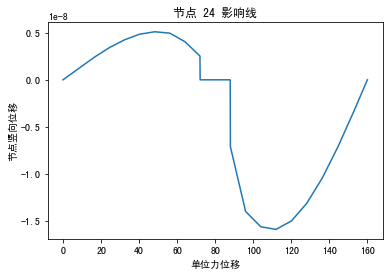

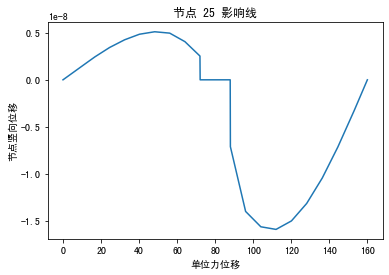

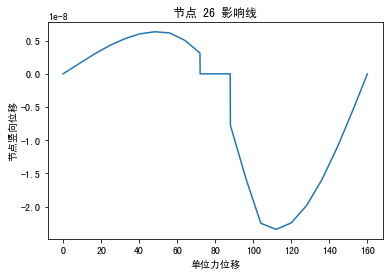

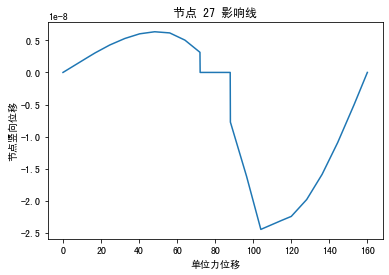

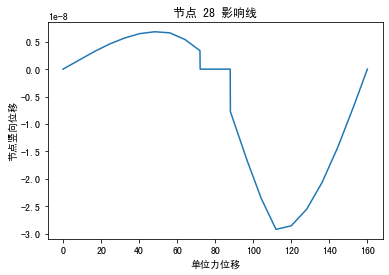

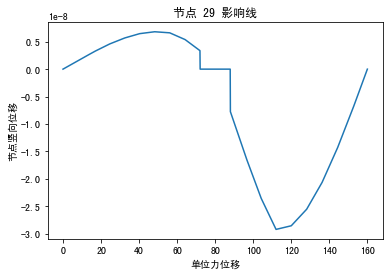

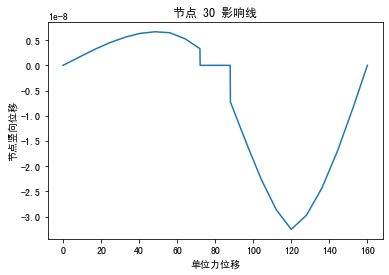

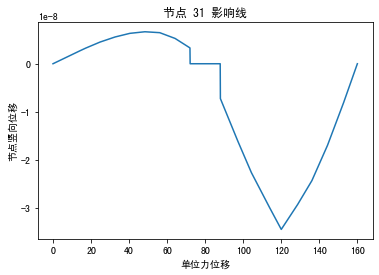

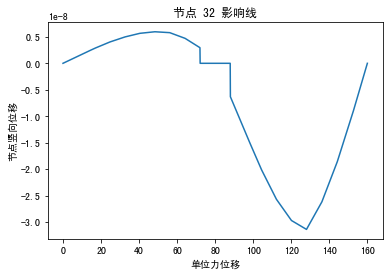

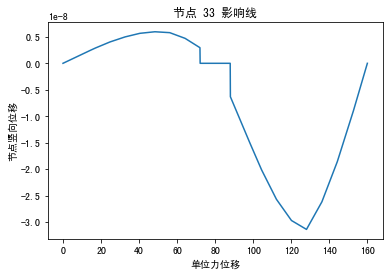

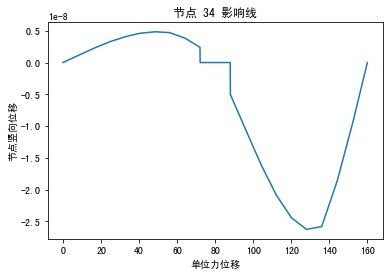

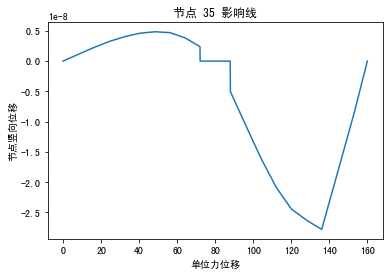

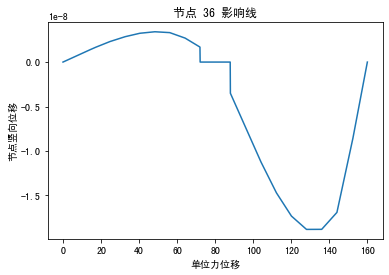

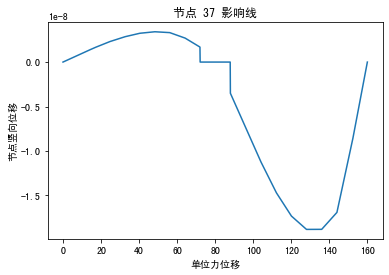

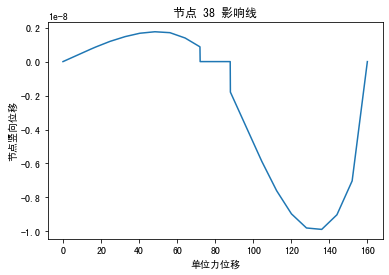

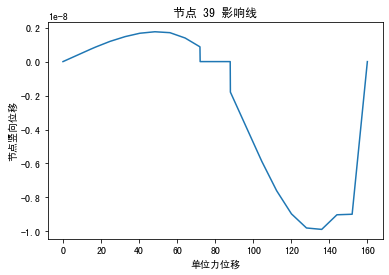

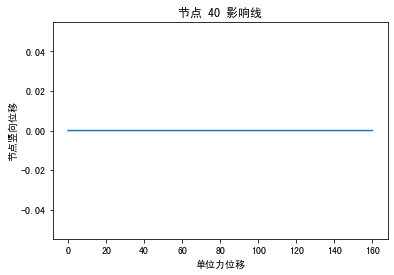

In [11]:
bridge.show_nodes_vdisps()

## 计算轴力

In [8]:
bridge.get_units_axial_forces()

所有杆件单元轴力已计算完毕.
所有零杆已标识.


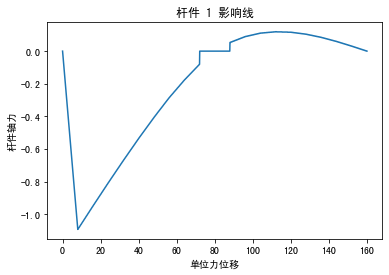

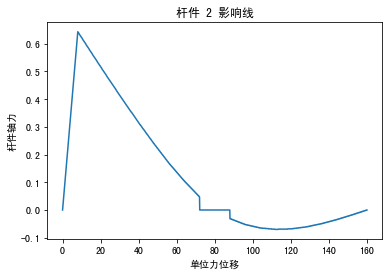

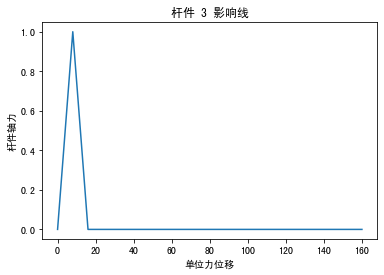

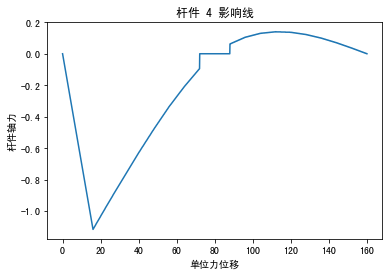

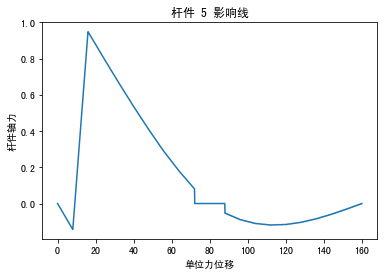

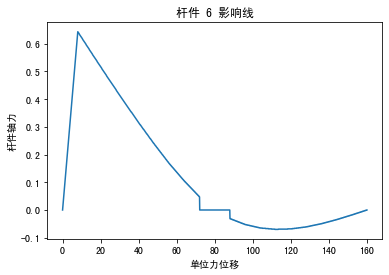

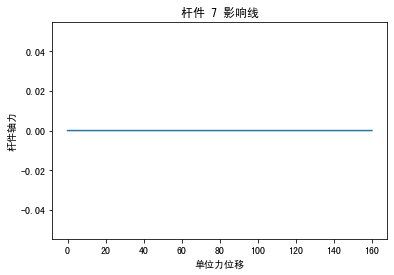

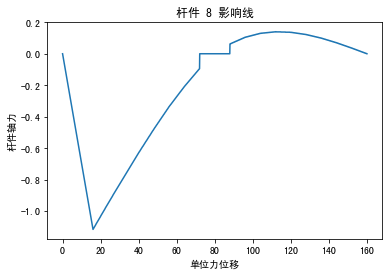

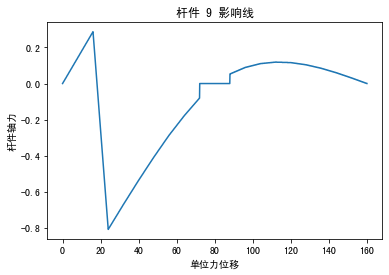

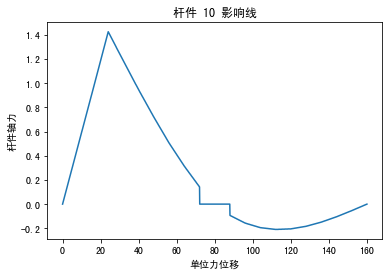

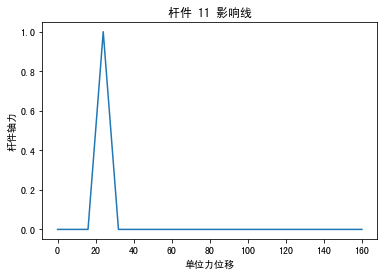

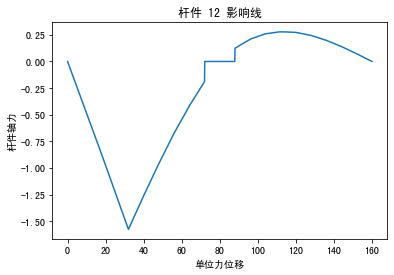

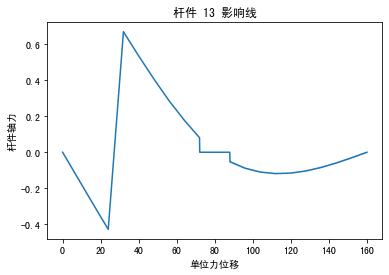

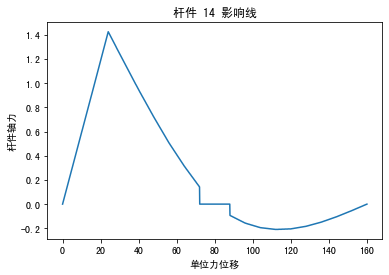

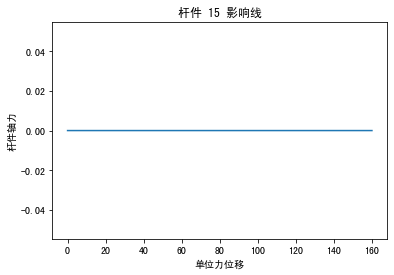

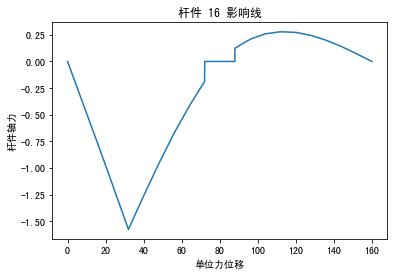

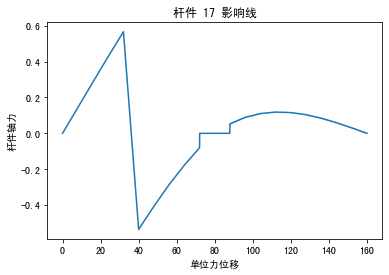

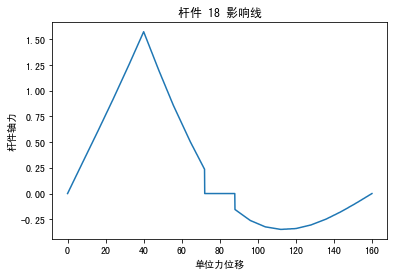

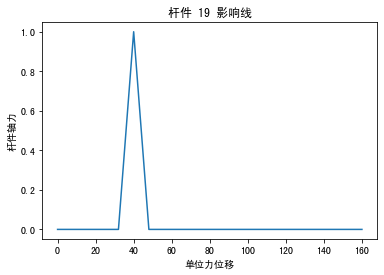

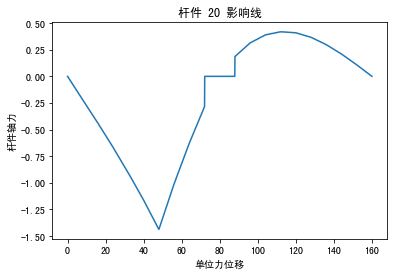

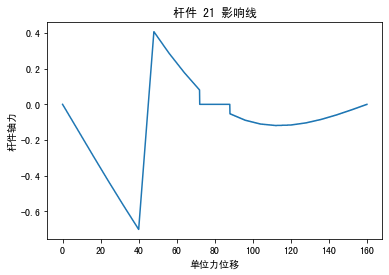

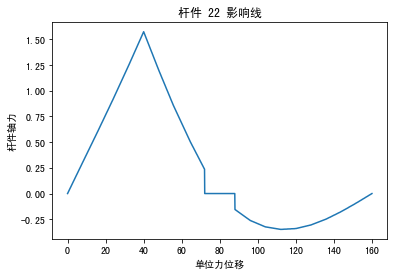

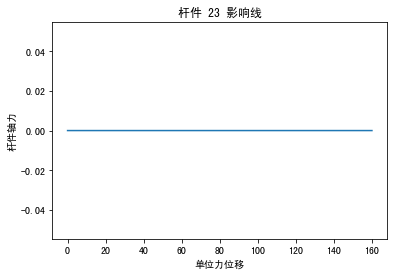

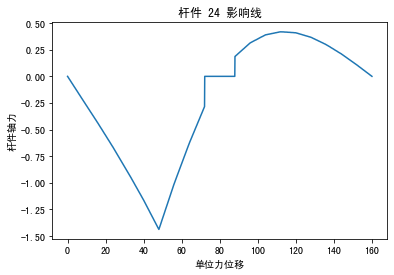

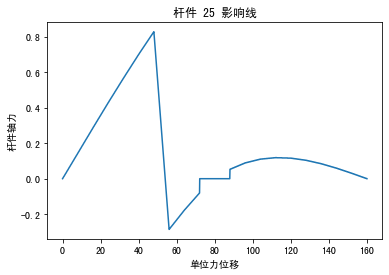

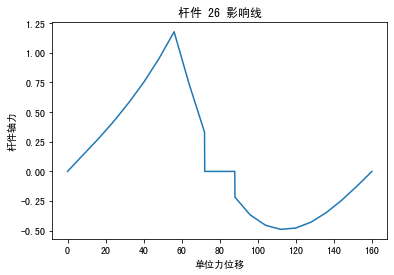

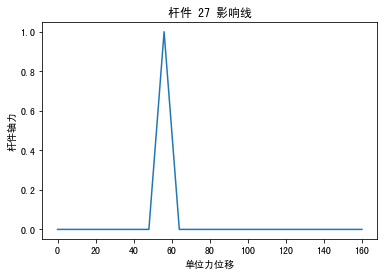

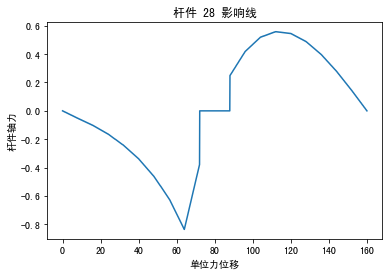

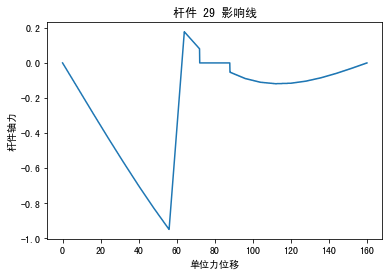

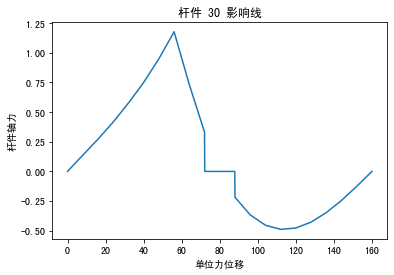

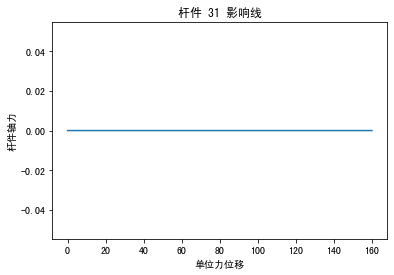

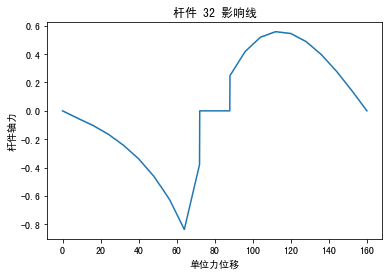

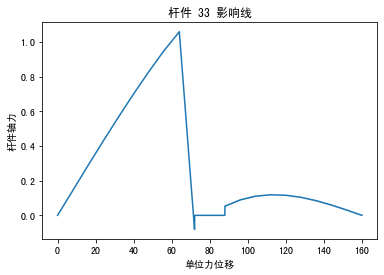

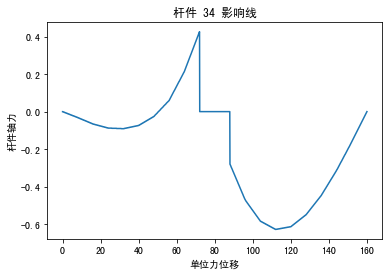

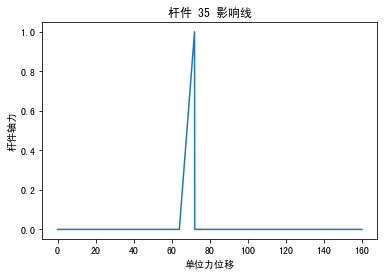

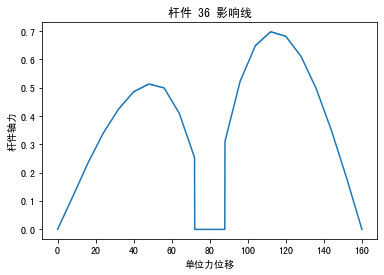

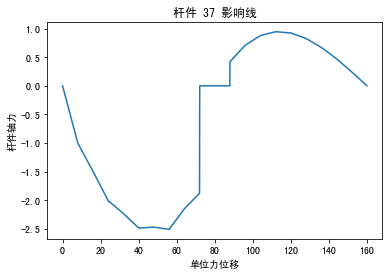

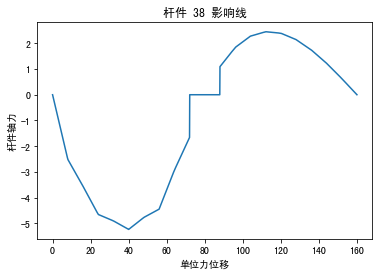

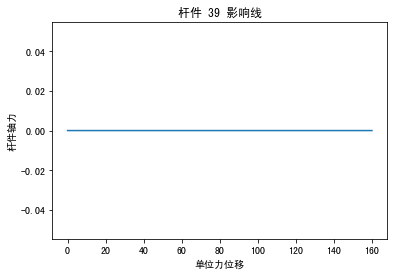

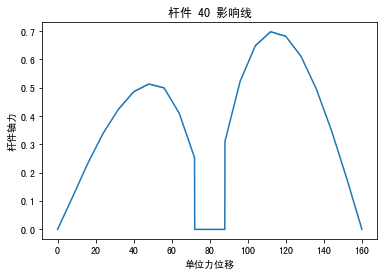

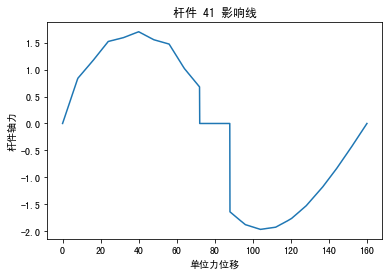

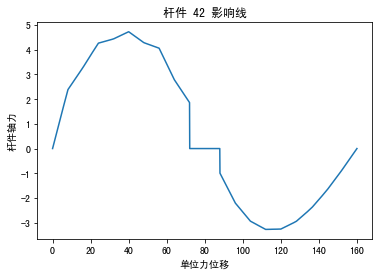

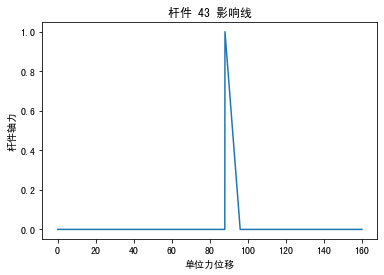

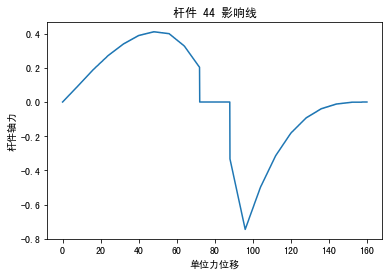

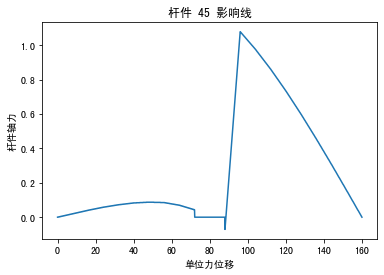

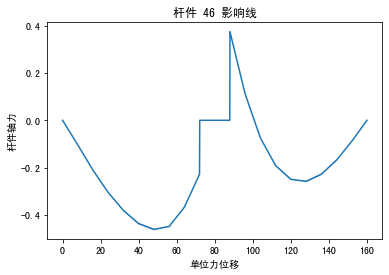

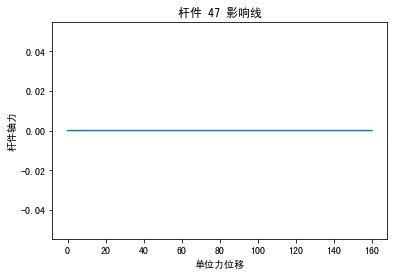

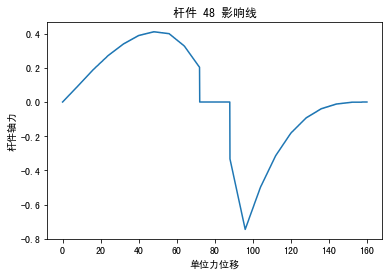

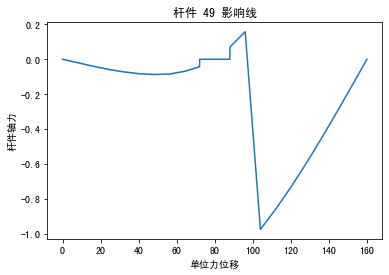

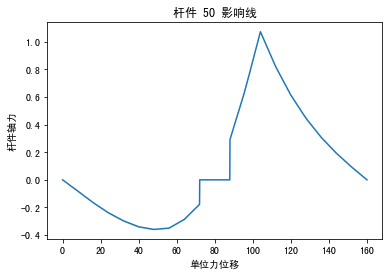

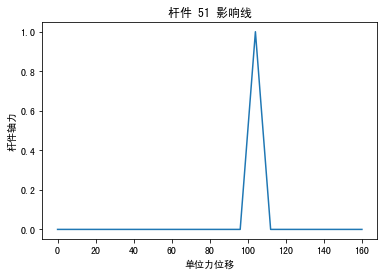

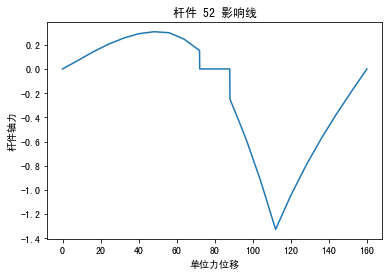

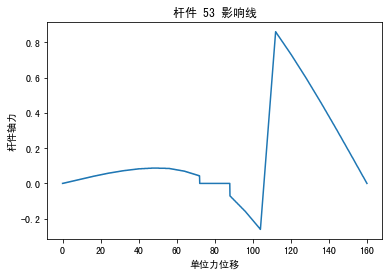

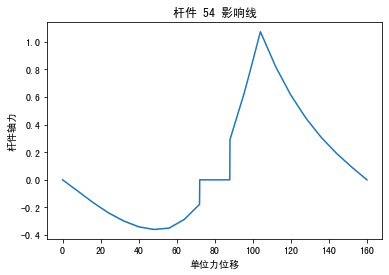

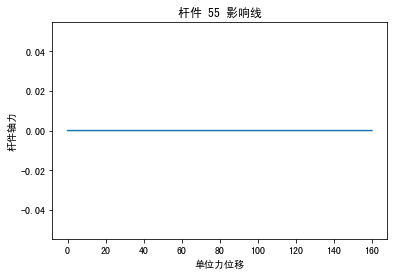

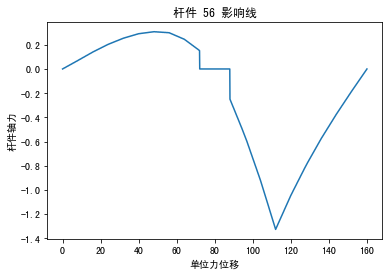

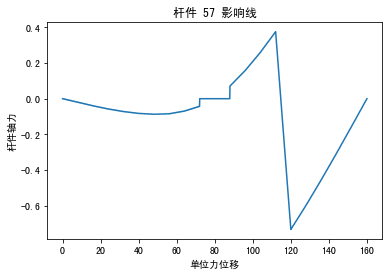

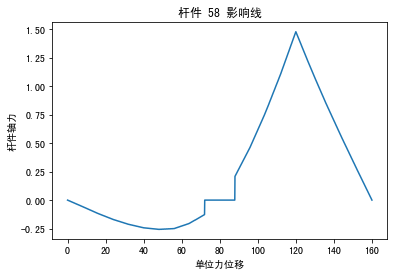

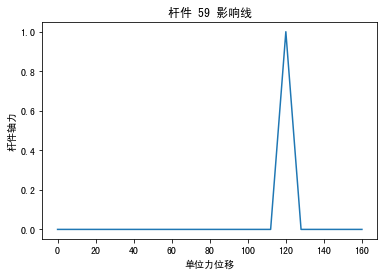

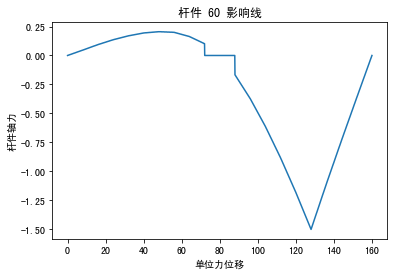

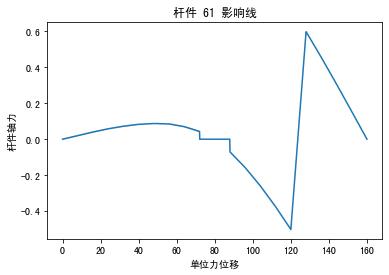

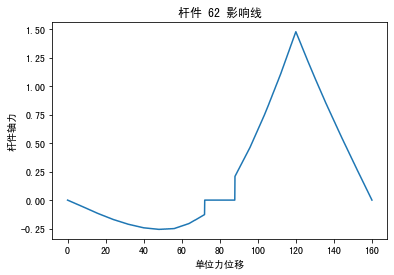

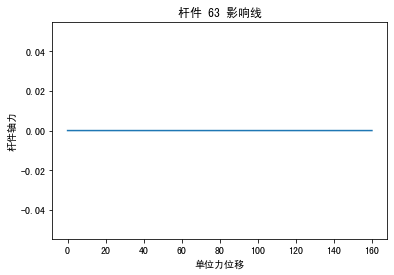

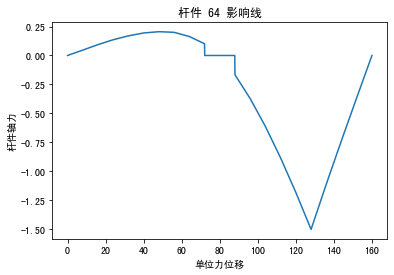

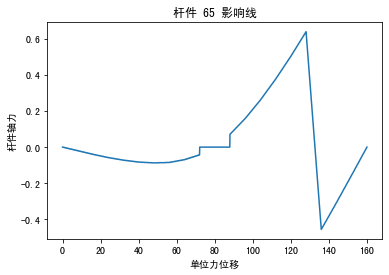

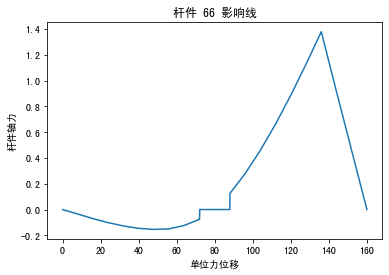

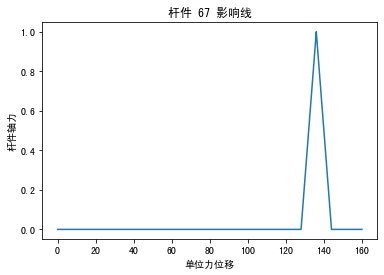

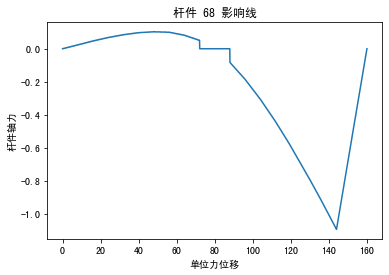

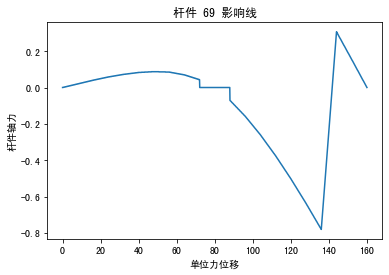

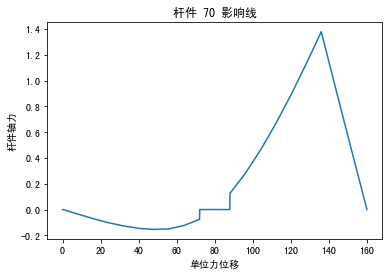

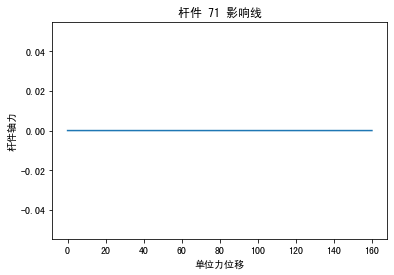

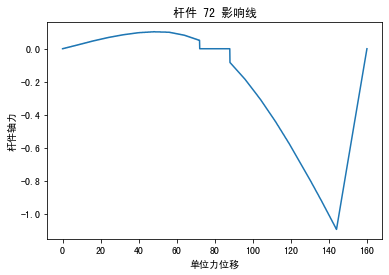

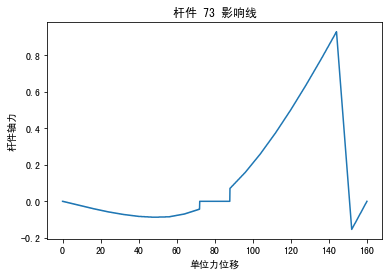

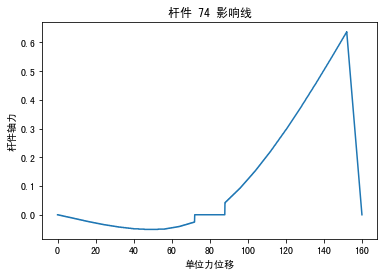

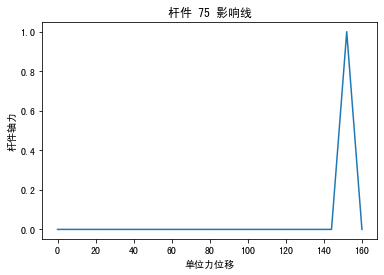

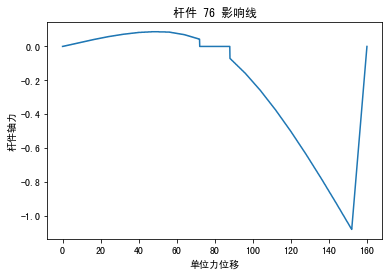

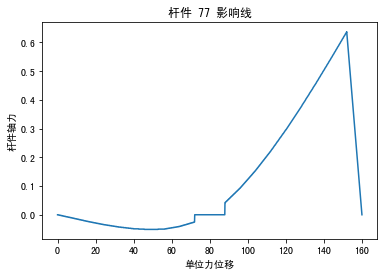

In [20]:
bridge.show_units_axial_forces()

In [9]:
bridge.show_zero_bars()

7 15 23 31 39 47 55 63 71 


## zk活载

In [10]:
bridge.get_worst_cases_load()

所有杆件单元最不利荷载已计算完毕.


In [23]:
for unit in bridge.units.values():
    print(unit.max_force)

(425.0673112377326, -2962.6164263692735)
(1742.5271330576222, -250.01256207687229)
(833.2800000000018, -6.501082289574755e-12)
(500.02512415373064, -3044.2421732474477)
(2314.268543438919, -466.60865753262397)
(1742.5271330576227, -250.0125620768723)
(2.7628310164743016e-12, -9.682126064451107e-12)
(500.0251241537286, -3044.2421732474404)
(644.1618603708331, -1750.1577179882859)
(3913.4494035242383, -750.0376862306064)
(833.2800000000065, -4.368760240446232e-12)
(1000.0502483074631, -4349.10006161141)
(1269.620730490092, -907.4382278800033)
(3913.449403524237, -750.0376862306064)
(1.3604775609131759e-12, -4.580707181866404e-13)
(1000.0502483074625, -4349.100061611409)
(1249.2039520776166, -870.5864587522665)
(4354.735404583642, -1250.0628103843374)
(833.2800000000125, -6.164454497582898e-12)
(1500.075372461205, -3936.5561256667083)
(550.8275914766807, -1666.3039587234498)
(4354.73540458364, -1250.0628103843374)
(2.0882834471393404e-13, -6.940698670860528e-12)
(1500.075372461206, -3936.

In [11]:
bridge.get_worst_cases_disps()

所有杆件单元最不利位移已计算完毕.


In [21]:
bridge.fatigue_check()

疲劳检算完成.


In [22]:
bridge.show_fatigue_check_results()

单元	合格	富余率
 1	是	\
 2	是	-0.832
 3	是	-0.937
 4	是	\
 5	是	-0.725
 6	是	-0.832
 7	是	\
 8	是	\
 9	是	\
10	是	-0.765
11	是	-0.937
12	是	\
13	是	-0.725
14	是	-0.765
15	是	\
16	是	\
17	是	-0.725
18	是	-0.765
19	是	-0.937
20	是	\
21	是	\
22	是	-0.765
23	是	\
24	是	\
25	是	-0.725
26	是	-0.832
27	是	-0.937
28	是	\
29	是	-0.832


In [32]:
bridge.strength_check()

强度检算完成.


In [33]:
bridge.show_strength_check_results()

### 强度检算 ###
单元	合格	富余率
 1	是	-0.426
 2	是	-0.362
 3	是	-0.918
 4	是	-0.284
 5	是	-0.183
 6	是	-0.362
 7	是	-1.000
 8	是	-0.284
 9	是	-0.415
10	是	-0.103
11	是	-0.918
12	是	-0.219
13	是	-0.606
14	是	-0.103
15	是	-1.000
16	是	-0.219
17	是	-0.606
18	是	-0.103
19	是	-0.918
20	是	-0.284
21	是	-0.415
22	是	-0.103
23	是	-1.000
24	是	-0.284
25	是	-0.183
26	是	-0.362
27	是	-0.918
28	是	-0.426
29	是	-0.362


In [51]:
bridge.stiffness_check()

刚度检算完成.


In [52]:
bridge.show_stiffness_check_results()

### 刚度检算 ###
单元	合格
 1	是
 2	是
 3	是
 4	是
 5	是
 6	是
 7	是
 8	是
 9	是
10	是
11	是
12	是
13	是
14	是
15	是
16	是
17	是
18	是
19	是
20	是
21	是
22	是
23	是
24	是
25	是
26	是
27	是
28	是
29	是


In [68]:
bridge.overall_stability_check()

整体稳定检算完成.


In [69]:
bridge.show_overall_stability_check_results()

### 整体稳定检算 ###
单元	合格
 1	是
 2	是
 3	是
 4	是
 5	是
 6	是
 7	是
 8	是
 9	是
10	是
11	是
12	是
13	是
14	是
15	是
16	是
17	是
18	是
19	是
20	是
21	是
22	是
23	是
24	是
25	是
26	是
27	是
28	是
29	是


In [73]:
bridge.show_check_results(which=2)

### 刚度 检算 ###
单元	合格	富余率


AttributeError: 'Unit' object has no attribute 'stiffness_surplus'

In [12]:
units_group = bridge.units_nums
# 梁截面数据([腹板宽度 翼缘厚度 腹板厚度 翼缘宽度])
#             b2       t1      t2     b1
b1, t1, b2, t2 = 0.215, 0.012, 0.436, 0.010
beam_section_data = [b1, t1, b2, t2]
bridge.check()
bridge.set_section_params(units_group, beam_section_data)
bridge.update()

当前修改参数杆件组： [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]
检算 => 总体刚度矩阵已重新计算.
检算 => 缩减总体刚度矩阵已重新计算.
所有节点竖向位移已计算完毕.
所有杆件单元轴力已计算完毕.
所有零杆已标识.
所有杆件单元最不利荷载已计算完毕.
所有杆件单元最不利位移已计算完毕.


In [25]:
import numpy as np
from sklearn.cluster import KMeans
from collections import OrderedDict
import matplotlib.pyplot as plt

target_units_nums = list(range(1, 40))
target_units_max_forces = [list(bridge.units[unit_num].max_force) for unit_num in target_units_nums]

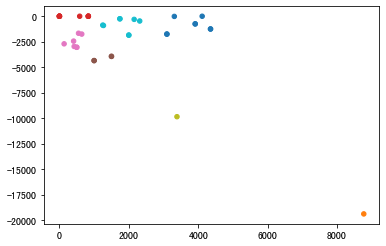

In [28]:
X = np.array(target_units_max_forces)
n_clusters = 7
kmeans = KMeans(n_clusters, max_iter=300, random_state=0).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], s=20, c=kmeans, cmap='tab10')

In [29]:
kmeans

array([4, 6, 2, 4, 6, 6, 2, 4, 4, 0, 2, 3, 6, 0, 2, 3, 6, 0, 2, 3, 4, 0,
       2, 3, 6, 0, 2, 6, 4, 0, 2, 6, 0, 4, 2, 0, 5, 1, 2], dtype=int32)

In [32]:
clusters = OrderedDict({label: [] for label in range(n_clusters)})
for unit_num, unit_max_forces, label in zip(target_units_nums, target_units_max_forces, kmeans):
    clusters[label].append(unit_num)
for label, cluster in clusters.items():
    print(label)
    for unit_num in cluster:
        print(unit_num, bridge.units[unit_num].max_force)
    print()

0
10 (3913.4494035242383, -750.0376862306064)
14 (3913.449403524237, -750.0376862306064)
18 (4354.735404583642, -1250.0628103843374)
22 (4354.73540458364, -1250.0628103843374)
26 (3097.497641298115, -1750.0879345380945)
30 (3097.4976412981105, -1750.0879345380931)
33 (3311.500264943061, -16.101299708669345)
36 (4114.076979200166, 0.0)

1
38 (8772.17989547976, -19387.123309477814)

2
3 (833.2800000000018, -6.501082289574755e-12)
7 (2.7628310164743016e-12, -9.682126064451107e-12)
11 (833.2800000000065, -4.368760240446232e-12)
15 (1.3604775609131759e-12, -4.580707181866404e-13)
19 (833.2800000000125, -6.164454497582898e-12)
23 (2.0882834471393404e-13, -6.940698670860528e-12)
27 (833.2800000000198, -6.7030178231463155e-12)
31 (1.6142063450618753e-12, -9.633260911608662e-13)
35 (584.0000000000001, -5.741393520369322e-13)
39 (8.646148801684047e-13, -4.908514831123889e-13)

3
12 (1000.0502483074631, -4349.10006161141)
16 (1000.0502483074625, -4349.100061611409)
20 (1500.075372461205, -3936.55

In [33]:
clusters

OrderedDict([(0, [10, 14, 18, 22, 26, 30, 33, 36]),
             (1, [38]),
             (2, [3, 7, 11, 15, 19, 23, 27, 31, 35, 39]),
             (3, [12, 16, 20, 24]),
             (4, [1, 4, 8, 9, 21, 29, 34]),
             (5, [37]),
             (6, [2, 5, 6, 13, 17, 25, 28, 32])])

In [ ]:
clusters_units_nums[2] += [43, 47, 51, 55, 59, 63, 67, 71, 75]
clusters_units_nums[1] += [42]
clusters_units_nums[5] += [41]
clusters_units_nums[6] += [44, 48, 53, 61, 65, 73, 74, 77]
clusters_units_nums[0] += [40, 45, 50, 54, 58, 62, 66, 70]
clusters_units_nums[3] += [52, 56, 60, 64]
clusters_units_nums[4] += [46, 49, 57, 68, 69, 72, 76]

In [63]:
bh_cases = []
B = [0.46, 0,60, 0.72]
H = [0.44, 0.60, 0.76]
c2_h = 0.44
for b in B:
    for c0_h in H:
        for c1_h in H:
            for c3_h in H:
                for c4_h in H:
                    for c5_h in H:
                        for c6_h in H:
                            # 7 类
                            # ((b, h), (b, h), ..., (b, h))
                            bh_cases.append(((b, c0_h), (b, c1_h), (b, c2_h), (b, c3_h), 
                                          (b, c4_h), (b, c5_h), (b, c6_h)))
len(bh_cases)

2916

In [ ]:
for bh_case in bh_cases:
    c0_bh, c1_bh, c2_bh, c3_bh, c4_bh, c5_bh, c6_bh = bh_case
    c0_b, c0_h = c1_bh
    c1_b, c1_h = c1_bh
    c2_b, c2_h = c1_bh
    c3_b, c3_h = c1_bh
    c4_b, c4_h = c1_bh
    c5_b, c5_h = c1_bh
    c6_b, c6_h = c1_bh
    for t1 in np.arrange(0.01, b, 0.01):
        b2 = b - 2 * t1
        for in np.arrange()

### 测试👇

In [11]:
print(zip([1, 2], [3, 4]))